In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import pdb
import requests
import matplotlib.pyplot as plt
from collections import defaultdict
import random 
import time

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import *

from functools import wraps
from time import time as _timenow 
from sys import stderr

## Load CIFAR-10 Data

In [2]:
def load_cifar():
    
    trn_data, trn_labels, tst_data, tst_labels = [], [], [], []
    def unpickle(file):
        with open(file, 'rb') as fo:
            data = pickle.load(fo, encoding='latin1')
        return data
    
    for i in trange(1):
        batchName = './data/data_batch_{0}'.format(i + 1)
        unpickled = unpickle(batchName)
        trn_data.extend(unpickled['data'])
        trn_labels.extend(unpickled['labels'])
    unpickled = unpickle('./data/test_batch')
    tst_data.extend(unpickled['data'])
    tst_labels.extend(unpickled['labels'])
    return trn_data, trn_labels, tst_data, tst_labels


## Image preprocessing

In [3]:
def image_prep(image):
    processed_image = image
#     m = np.mean(image, axis=0)
#     sd = np.std(image, axis=0)
#     processed_image = image - m
#     processed_image = processed_image/sd
    ''' pre-processes the given image
        performs mean normalization and other such operations'''
    return processed_image

## Dimensionality reduction using PCA

In [4]:
def reduce_dim(**kwargs):
    dim = kwargs['dim']
    train_X = kwargs['train_X']
    train_y = kwargs['train_y']
    ''' performs dimensionality reduction'''
    if kwargs['method'] == 'pca':
        pca = PCA(n_components=dim)
        pca.fit(train_X)
        X_reduced = pca.transform(train_X)
        return pca, X_reduced
    
    if kwargs['method'] == 'lda':
        lda = LinearDiscriminantAnalysis(n_components=dim)
        lda.fit(train_X,train_y)
        X_reduced = lda.transform(train_X)
        return lda, X_reduced        

## Classification using kernel SVM

In [5]:
def classify(X, y, **kwargs):
    ''' trains a classifier by taking input features
        and their respective targets and returns the trained model'''
    if kwargs['method'] == 'Logistic Regression':
        clf = LogisticRegression()
        clf = clf.fit(X, y)
        return clf
    if kwargs['method'] == 'Decision Tree':
        clf = tree.DecisionTreeClassifier()
        clf = clf.fit(X, y)
        return clf

## Evaluation 

In [6]:
def evaluate(target, predicted):
    f1 = f1_score(target, predicted, average='micro')
    acc = accuracy_score(target, predicted)
    return f1, acc

In [7]:
def test(**kwargs):
    classifer_model = kwargs['classifer_model']
    test_X = kwargs['test_X']
    test_y = kwargs['test_y']
    predicted_y = classifer_model.predict(test_X)
    f1, acc = evaluate(test_y, predicted=predicted_y)
    print(f1)
    print(acc)
    return f1, acc

In [8]:
dec_PCA_acc = []
dec_PCA_f1 = []
def main1():
    trn_data, trn_labels, tst_data, tst_labels = load_cifar()
    trn_data, tst_data = list(map(image_prep, trn_data)), list(map(image_prep, tst_data))
    X_train, X_val, y_train, y_val = train_test_split(trn_data, trn_labels,test_size = 0.20)
    scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
    X_train = scaling.transform(X_train)
    X_val = scaling.transform(X_val)
    
#     dims=[60,61,62,63,64,65,67,68,69]
    dims=[1,2,4,8,16,32,64,128,256,512,1024]
    for dim in dims:
        print(dim)
        reduced_model, X_reduced = reduce_dim(method='pca',dim=dim,train_X = X_train,train_y = y_train)
        classifer_model = classify(X_reduced, y_train, method='Decision Tree')
        test_X_reduced = reduced_model.transform(X_val)
        f1, acc = test(classifer_model=classifer_model,test_X = test_X_reduced, test_y = y_val)
        dec_PCA_acc.append(acc)
        dec_PCA_f1.append(f1)
    
    ''' perform dimesioality reduction/feature extraction and classify the features into one of 10 classses
        print accuracy and f1-score.
        '''
#     print('Val - F1 score: {}\n Accuracy: {}'.format(f_score, accuracy_))


In [9]:
if __name__ == '__main__':
    main1()

100%|██████████| 1/1 [00:00<00:00, 16.84it/s]


1
0.1135
0.1135
2
0.1355
0.1355
4
0.187
0.187
8
0.2005
0.2005
16
0.241
0.241
32
0.254
0.254
64
0.2545
0.2545
128
0.2315
0.2315
256
0.226
0.226
512
0.2015
0.2015
1024
0.221
0.221


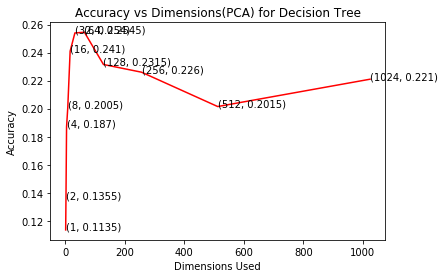

In [10]:
dims=[1,2,4,8,16,32,64,128,256,512,1024]
for i in range(1,len(dec_PCA_acc)):
#     print(i)
    dec_PCA_f1[i] = round(dec_PCA_f1[i], 3)
#     print(i)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(dims,dec_PCA_acc,'r')
plt.xlabel('Dimensions Used')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Dimensions(PCA) for Decision Tree')
for xy in zip(dims, dec_PCA_acc):
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.savefig('finaldecisiontree_PCA_accuracy_2.svg',format='svg')

In [11]:
print(dims)
data = {'Dimensions' : dims,
        'Accuracy':dec_PCA_f1,
#         'Score':svm_PCA_f1
       }
p = pd.DataFrame(data)
columnsTitles=["Dimensions","Accuracy"]
p = p.reindex(columns=columnsTitles)
p.index = range(1,12)
# print(p)
# print(svm_PCA_f1)
p

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


,Dimensions,Accuracy
1,1,0.1135
2,2,0.1360
3,4,0.1870
4,8,0.2000
5,16,0.2410
6,32,0.2540
7,64,0.2540
8,128,0.2320
9,256,0.2260
10,512,0.2020


In [12]:
def sethyperparam(X, y, **kwargs):
     if kwargs['method'] == 'Decision Tree':
            criterion = kwargs['criterion']
            max_depth = kwargs['max_depth']
            clf = tree.DecisionTreeClassifier(criterion  = criterion, max_depth=max_depth)
            clf = clf.fit(X, y)
            return clf

In [13]:
trn_data, trn_labels, tst_data, tst_labels = load_cifar()
trn_data, tst_data = list(map(image_prep, trn_data)), list(map(image_prep, tst_data))
X_train, X_val, y_train, y_val = train_test_split(trn_data, trn_labels,test_size = 0.20)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_val = scaling.transform(X_val)
tst_data = scaling.transform(tst_data)
 
reduced_model, X_reduced = reduce_dim(method='pca',dim=40,train_X = X_train,train_y = y_train)
test_X_reduced = reduced_model.transform(X_val)
reducedtestdata = reduced_model.transform(tst_data)

100%|██████████| 1/1 [00:00<00:00, 21.01it/s]


In [14]:
criterion_range = ['gini', 'entropy']
max_depth_range = [3,6,12,30,60,120]
svm_PCA_acc1 = []
svm_PCA_f11 = []
def main2():
    for criteria in criterion_range:
        for max_depth in max_depth_range:
            print(criteria, max_depth)
            classifer_model = sethyperparam(X_reduced, y_train, method='Decision Tree', max_depth=max_depth, criterion=criteria)
            testf1, testacc = test(classifer_model=classifer_model,test_X = test_X_reduced, test_y = y_val)
            trainf1, trainacc = test(classifer_model=classifer_model,test_X = X_reduced, test_y = y_train)
            svm_PCA_acc1.append(testacc)
            svm_PCA_f11.append(trainacc)
main2()

gini 3
0.208
0.208
0.22662499999999997
0.226625
gini 6
0.2785
0.2785
0.323375
0.323375
gini 12
0.2555
0.2555
0.696125
0.696125
gini 30
0.221
0.221
1.0
1.0
gini 60
0.22400000000000003
0.224
1.0
1.0
gini 120
0.2295
0.2295
1.0
1.0
entropy 3
0.2185
0.2185
0.232625
0.232625
entropy 6
0.26
0.26
0.30975
0.30975
entropy 12
0.249
0.249
0.747625
0.747625
entropy 30
0.236
0.236
1.0
1.0
entropy 60
0.234
0.234
1.0
1.0
entropy 120
0.237
0.237
1.0
1.0


In [15]:
temp_C = []
temp_gamma = []
for i in range(len(criterion_range)):
    for j in range (len(max_depth_range)):
        temp_C.append(criterion_range[i])
        temp_gamma.append(max_depth_range[j])        

In [16]:
print(temp_C)
print(temp_gamma)
print(svm_PCA_acc1)
print(svm_PCA_f11)

['gini', 'gini', 'gini', 'gini', 'gini', 'gini', 'entropy', 'entropy', 'entropy', 'entropy', 'entropy', 'entropy']
[3, 6, 12, 30, 60, 120, 3, 6, 12, 30, 60, 120]
[0.208, 0.2785, 0.2555, 0.221, 0.224, 0.2295, 0.2185, 0.26, 0.249, 0.236, 0.234, 0.237]
[0.226625, 0.323375, 0.696125, 1.0, 1.0, 1.0, 0.232625, 0.30975, 0.747625, 1.0, 1.0, 1.0]


In [17]:
data1 = {'Criteria' : temp_C,
         'Max depth' : temp_gamma,
         'Test Accuracy' : svm_PCA_acc1,
         'Train Accuracy' : svm_PCA_f11
#         'Score':svm_PCA_f1
       }
p1 = pd.DataFrame(data1)
columnsTitles=["Criteria","Max depth", "Test Accuracy", "Train Accuracy"]
p1 = p1.reindex(columns=columnsTitles)
p1.index = range(1,13)
p1

,Criteria,Max depth,Test Accuracy,Train Accuracy
1,gini,3,0.2080,0.226625
2,gini,6,0.2785,0.323375
3,gini,12,0.2555,0.696125
4,gini,30,0.2210,1.000000
5,gini,60,0.2240,1.000000
6,gini,120,0.2295,1.000000
7,entropy,3,0.2185,0.232625
8,entropy,6,0.2600,0.309750
9,entropy,12,0.2490,0.747625
10,entropy,30,0.2360,1.000000


In [18]:
classifer_model = classifer_model = sethyperparam(X_reduced, y_train, method='Decision Tree', max_depth=6, criterion="gini")
testf1, testacc = test(classifer_model=classifer_model,test_X = test_X_reduced, test_y = y_val)
test(classifer_model=classifer_model,test_X = reducedtestdata, test_y = tst_labels)

0.2785
0.2785
0.2755
0.2755


(0.2755, 0.2755)